# Tutorial 06 - Classification
# Fashion MNIST with logistic regression and neural network

In [86]:
# Import the required libraries

import numpy as np
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
import math

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from scipy.stats import randint 

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as gobj

init_notebook_mode(connected=True)
import plotly.figure_factory as ff

# Ignore and Ignore Warnings
# import warnings
# warnings.filterwarnings('ignore')

# To display all the columns
# pd.options.display.max_columns = None

# To display all the rows
# pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
# pd.options.mode.use_inf_as_na = True

# pd.options.display.expand_frame_repr =  False

%matplotlib inline

# Set Style
sns.set(style = "whitegrid")

# Load the Data
In this demo we will use a sample of Fashion MNIST dataset in a CSV format.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Instead of using full dataset with 60000 training examples we will use cut dataset of just 5000 examples that we will also split into training and testing sets.

Each row in the dataset consists of 785 values: the first value is the label (a category from 0 to 9) and the remaining 784 values (28x28 pixels image) are the pixel values (a number from 0 to 255).

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [87]:
# Load the data.
df = pd.read_csv('fashion-mnist-demo.csv')

# Laets create the mapping between numeric category and category name.
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

# Print the data table.
df.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


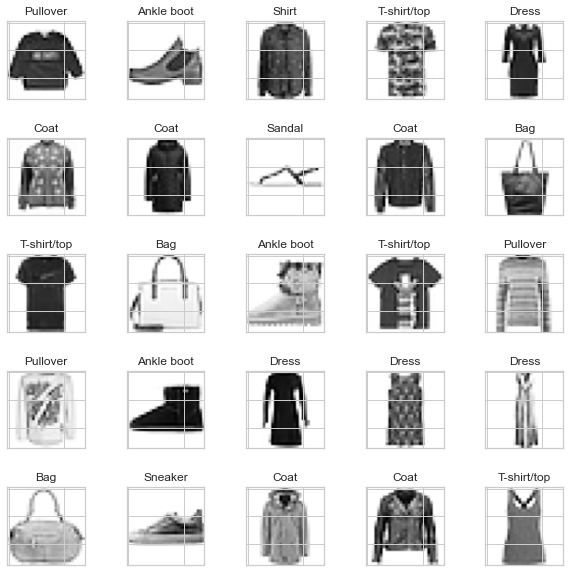

In [88]:
# How many images to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the images.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the first images in a training set and plot them.
for plot_index in range(numbers_to_display):
    # Extrace image data.
    digit = df[plot_index:plot_index + 1].values
    digit_label = digit[0][0]
    digit_pixels = digit[0][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the image matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(label_map[digit_label])
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Train/test split

In [89]:
# Separating dependent and independent variables
X = np.array(df.drop(['label'], axis = 1))
y = np.array(df['label'])

In [90]:
# Splitting the data into training and test set in the ratio of 80:20 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 784)

(1000, 784)

(4000,)

(1000,)

In [91]:
LR = LogisticRegression()
model = LR.fit(X_train,y_train)
y_pred = model.predict(X_test)

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [93]:
y_pred = model.predict_proba(X_test)

In [94]:
y_pred[0]

array([1.74813544e-01, 2.53569019e-03, 3.91296033e-04, 8.20559878e-01,
       1.58200610e-04, 5.95724923e-17, 8.18816706e-06, 4.35234119e-19,
       1.53320392e-03, 3.72645514e-18])

# Evaluation Report function

In [95]:
# Custom Function to get Scores and plots...
def Generate_Model_Test_Classification_Report(model, X_train, y_train, X_test, y_test, model_name=""):

    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Mathews Correlation Coefficient (MCC)
            6. Precision
            7. Recall
            8. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            9. AUC-PR Score - Area Under the Precision Recall Curve.
            10. AUROC Curve - Area Under the Receiver Operating Characteristic Curve
            11. AUC-PR Curve - Area Under the Precision Recall Curve.

    Return Value: 
        model
    '''
    
    # train the model
    model.fit(X_train, y_train)

    # Report Title & Class Abbreviations
    fig, axes = plt.subplots(2, 1, figsize = (1, 1))

    axes[0].text(0, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, color='DarkOrange', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(0, 4, label_map, 
                 style='italic', fontsize=10, color='orangered')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Classification report and confusion matrix
    class_report = classification_report(y_test, y_pred)
    conf_matx = confusion_matrix(y_test, y_pred)

    # Display the Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize = (20, 10))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left', y=1.0)

    # Classification Report
    axes[1].axis([0, 10, 0, 3])
    axes[1].text(0, 1, class_report, style='italic', fontsize=20)
    axes[1].axis('off')
    axes[1].set_title("2. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=1.0, x=0.3)

    plt.tight_layout()
    plt.show()
    
    return model

# Part A: Machine Learning Models
# Model 1: Logistic Regression

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



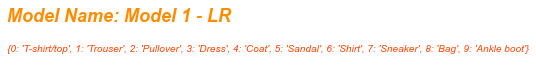

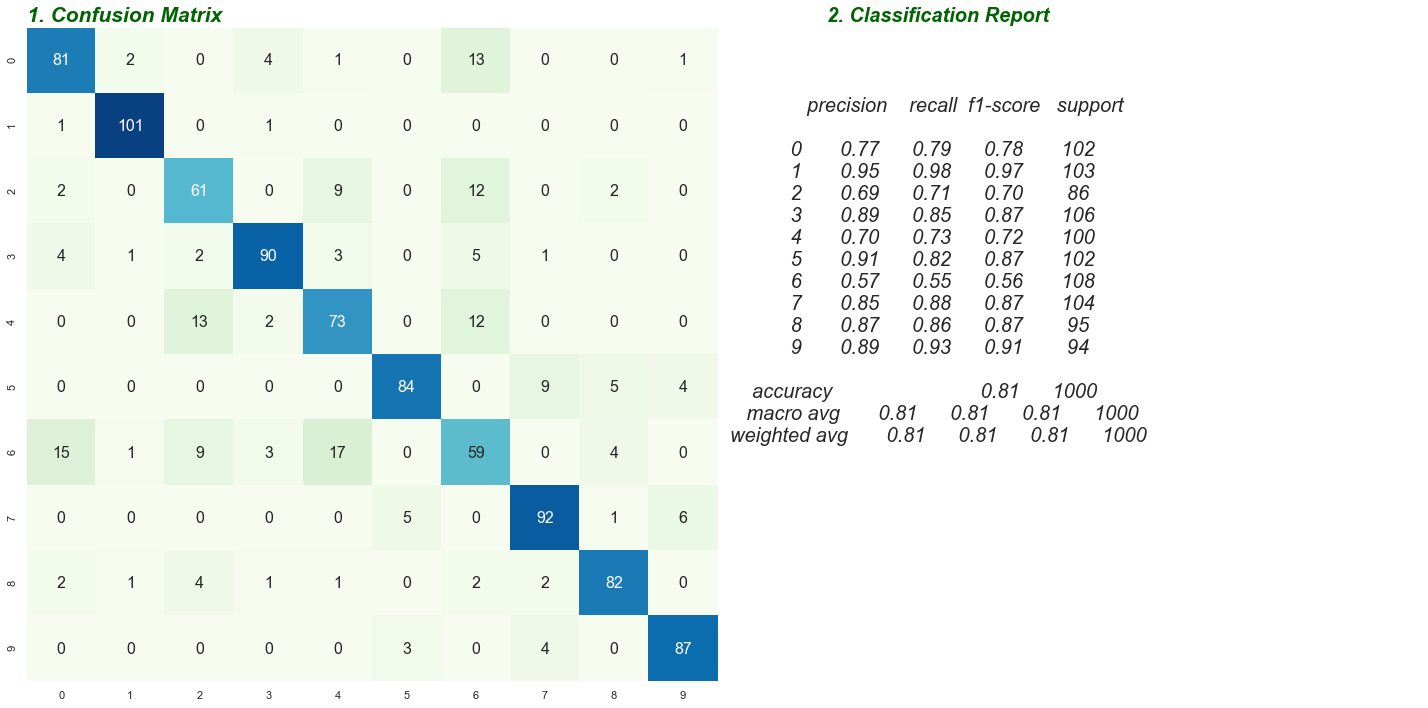

Wall time: 2.56 s


In [96]:
%%time
# LR model without hyperparameter tuning
LR = LogisticRegression()
model1 = Generate_Model_Test_Classification_Report(LR, X_train, y_train, X_test, y_test, "Model 1 - LR")

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



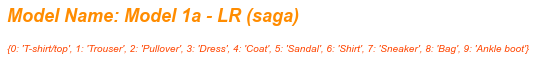

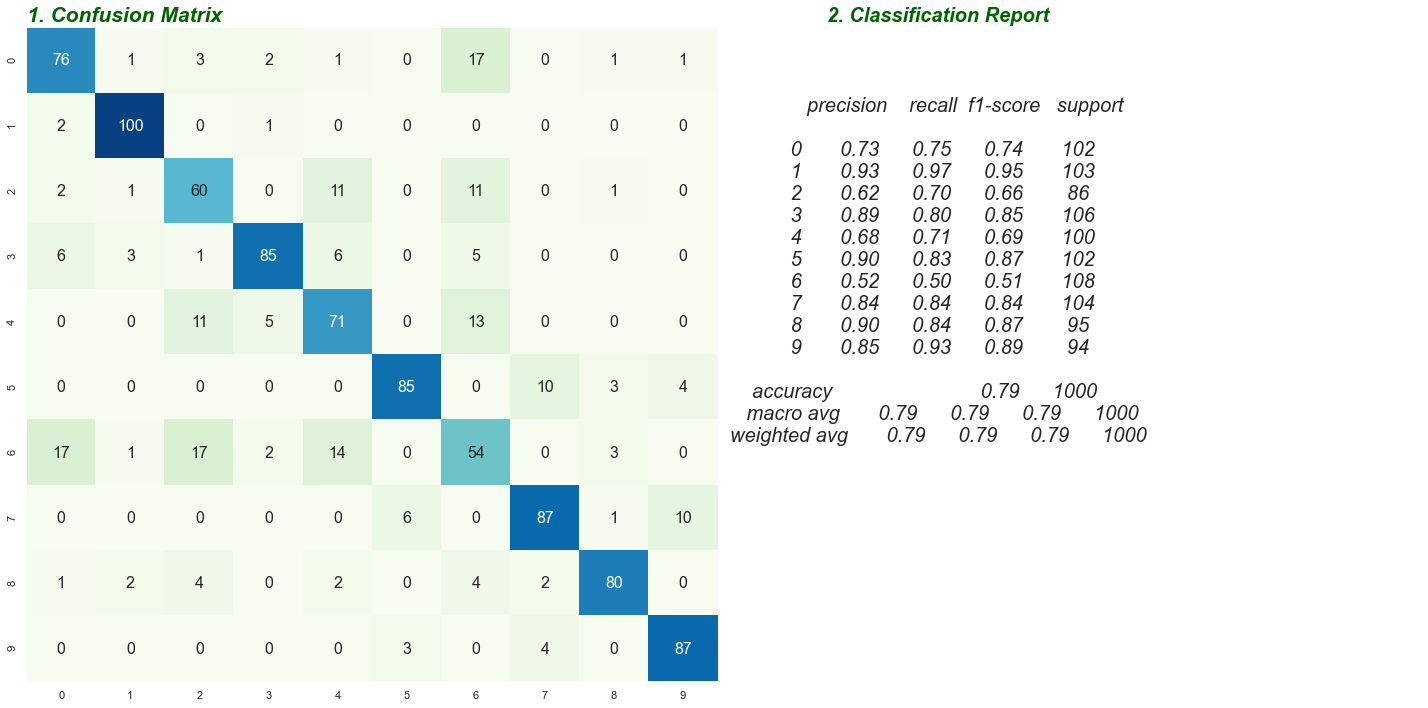

Wall time: 3.67 s


In [97]:
%%time
# LR model without increased max_iter
LR = LogisticRegression(max_iter=200)
model1 = Generate_Model_Test_Classification_Report(LR, X_train, y_train, X_test, y_test, "Model 1a - LR (saga)")

# Model 2: Logistic Regression with tuning

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [    nan 0.805       nan 0.805       nan 0.80275     nan 0.80425     nan
 0.804  ]

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



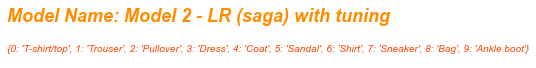

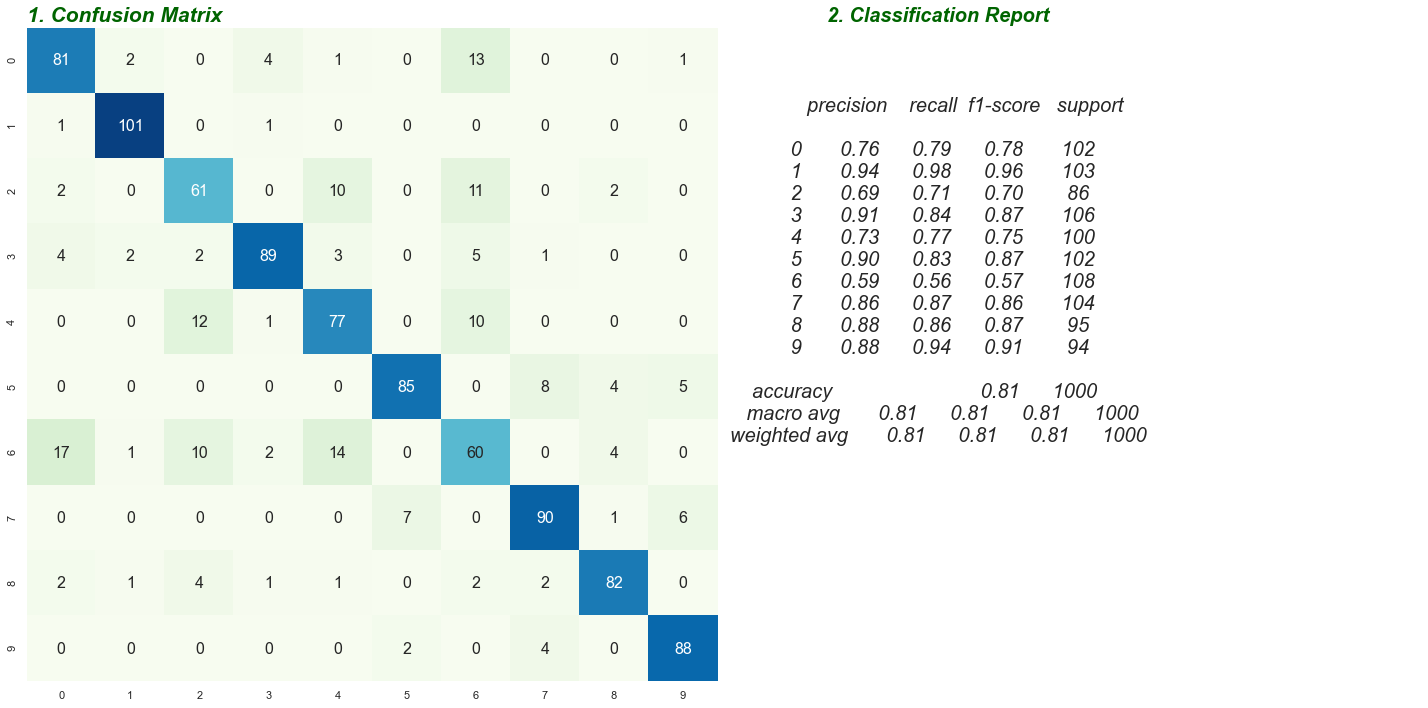

Wall time: 18.3 s


In [98]:
%%time
LR = LogisticRegression()

params = {'penalty': ['l1', 'l2',], 
          'C': [0.001, 0.01, 0.1, 1, 10]}

skf = StratifiedKFold(n_splits = 5)
LR_hyper = GridSearchCV(LR, param_grid = params, n_jobs = -1, cv = skf)

model2 = Generate_Model_Test_Classification_Report(LR_hyper, X_train, y_train, X_test, y_test, "Model 2 - LR (saga) with tuning")

In [99]:
model2.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'n_jobs': -1,
 'param_grid': {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

# Model 3: XgBoost

C:\Users\v13260\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[11:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


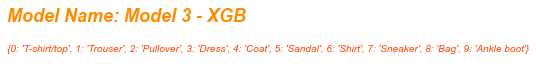

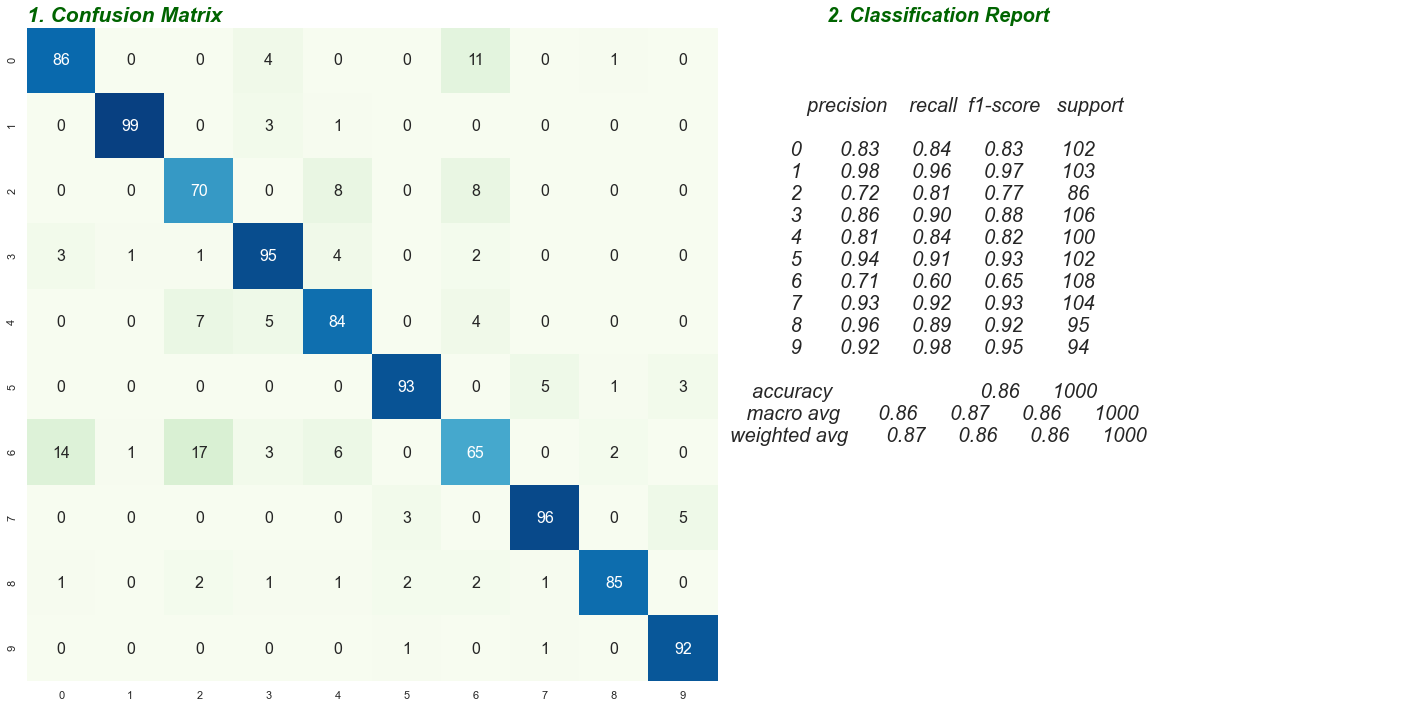

Wall time: 33.9 s


In [100]:
%%time
# XGB model without hyperparameter tuning
XGB = XGBClassifier()
model3 = Generate_Model_Test_Classification_Report(XGB, X_train, y_train, X_test, y_test, "Model 3 - XGB")

# Checking the image predictions

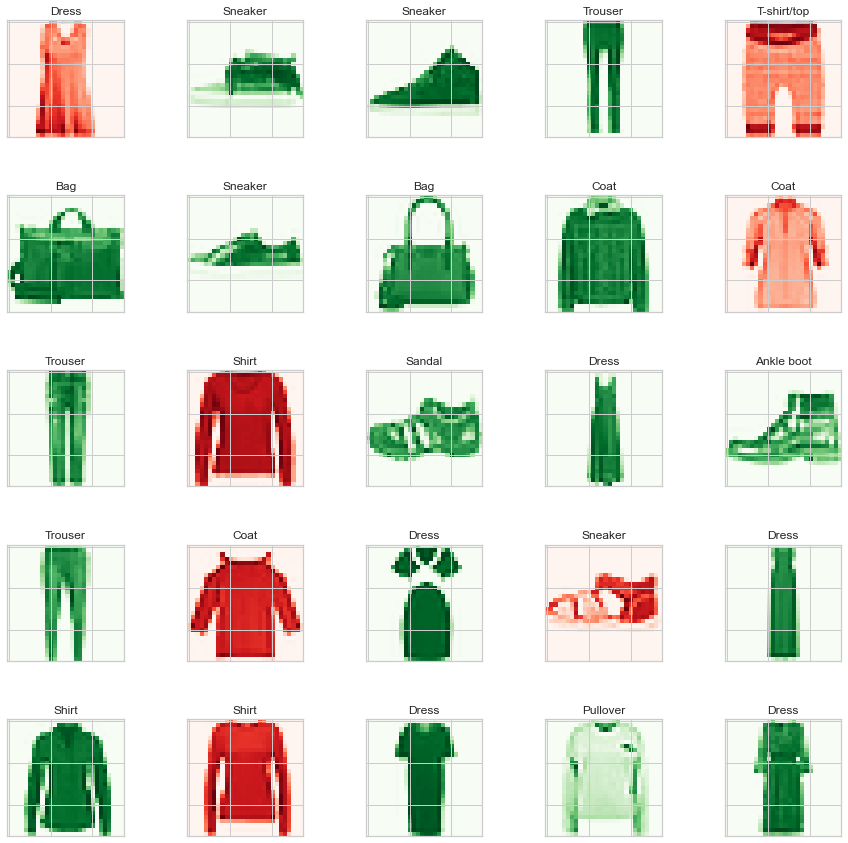

In [101]:
# How many numbers to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the numbers.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(15, 15))

# Go through the first numbers in a test set and plot them.
for plot_index in range(numbers_to_display):
    # Extrace digit data.
    digit_label = y_test[plot_index]
    digit_pixels = X_test[plot_index, :]
    
    # Predicted label.
    y_test_predictions = model2.predict(X_test)
    predicted_label = y_test_predictions[plot_index]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the number matrix.
    color_map = 'Greens' if predicted_label == digit_label else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap=color_map)
    plt.title(label_map[predicted_label])
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Part B: Deep Learning Models

In [106]:
# TensorFlow and tf.keras
import tensorflow as tf

In [107]:
# reshape data back to 28x28 pixels image
X_image = X.reshape(len(X),28,28)
X_image.shape

(5000, 28, 28)

In [108]:
# Splitting the data into training and test set in the ratio of 80:20 respectively
X_train, X_test, y_train, y_test = train_test_split(X_image, y, test_size = 0.2, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 28, 28)

(1000, 28, 28)

(4000,)

(1000,)

In [109]:
# A simple Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [110]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
%%time
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
125/125 [==============================] - 1s 1ms/step - loss: 47.5060 - accuracy: 0.5563
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 10.6323 - accuracy: 0.7503
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 6.8508 - accuracy: 0.7454
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 3.3942 - accuracy: 0.7776
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 1.2832 - accuracy: 0.6901
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 1.0229 - accuracy: 0.7048
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.8210 - accuracy: 0.7251
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7832 - accuracy: 0.7155
Epoch 9/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.7682
Epoch 10/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6280 - accuracy: 0.77

In [112]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
y_pred = probability_model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [113]:
class_report = classification_report(y_test, y_classes)
conf_matx = confusion_matrix(y_test, y_classes)

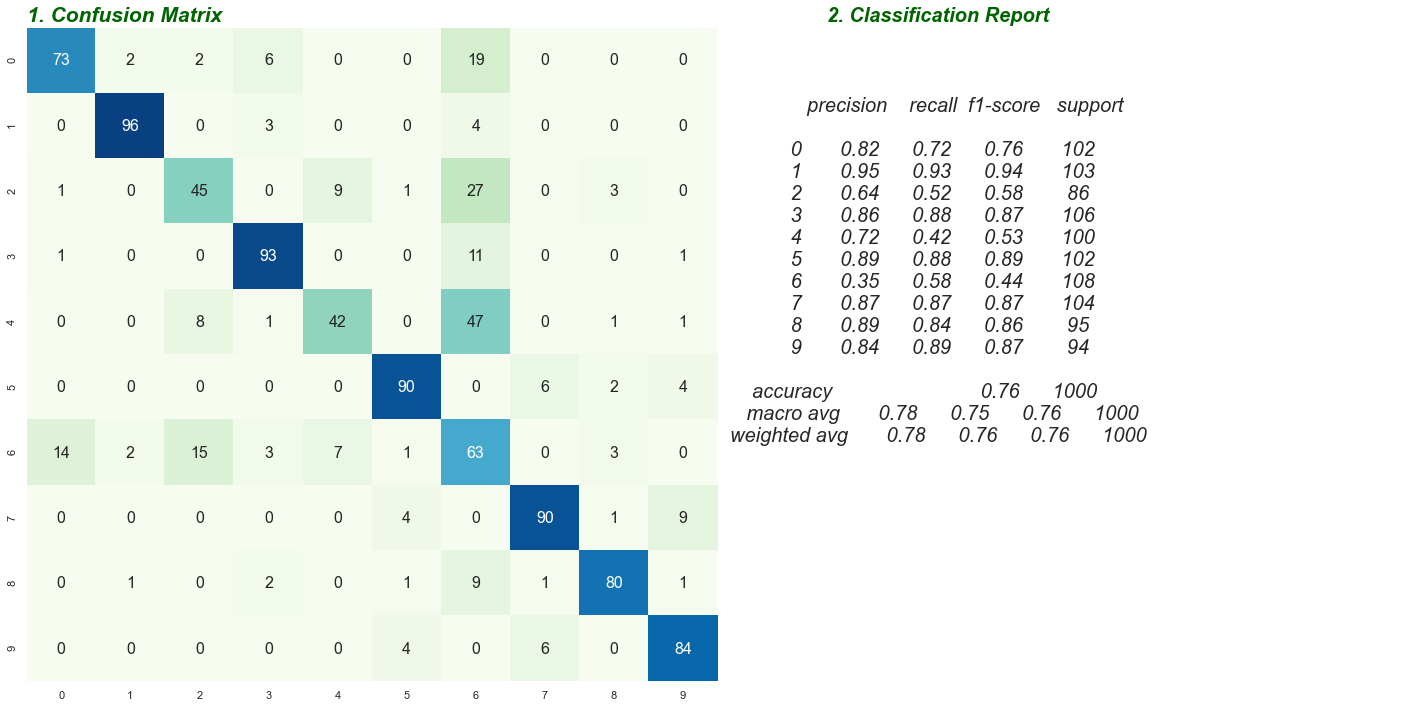

In [114]:
# Display the Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                  style='italic', loc='left', y=1.0)

# Classification Report
axes[1].axis([0, 10, 0, 3])
axes[1].text(0, 1, class_report, style='italic', fontsize=20)
axes[1].axis('off')
axes[1].set_title("2. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                  style='italic', loc='center', y=1.0, x=0.3)

plt.tight_layout()
plt.show()

# simple CNN

In [115]:
# reshape data back to 28x28x1 pixels image
X_image = X.reshape(len(X),28,28,1)
X_image.shape

(5000, 28, 28, 1)

In [116]:
# Splitting the data into training and test set in the ratio of 80:20 respectively
X_train, X_test, y_train, y_test = train_test_split(X_image, y, test_size = 0.2, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 28, 28, 1)

(1000, 28, 28, 1)

(4000,)

(1000,)

In [117]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10))

In [118]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [119]:
%%time
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
125/125 [==============================] - 6s 43ms/step - loss: 8.2843 - accuracy: 0.6069
Epoch 2/10
125/125 [==============================] - 5s 43ms/step - loss: 0.4183 - accuracy: 0.8503
Epoch 3/10
125/125 [==============================] - 5s 42ms/step - loss: 0.2625 - accuracy: 0.9018
Epoch 4/10
125/125 [==============================] - 5s 42ms/step - loss: 0.1972 - accuracy: 0.9301
Epoch 5/10
125/125 [==============================] - 5s 43ms/step - loss: 0.1369 - accuracy: 0.9528
Epoch 6/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0763 - accuracy: 0.9764
Epoch 7/10
125/125 [==============================] - 5s 44ms/step - loss: 0.0691 - accuracy: 0.9770
Epoch 8/10
125/125 [==============================] - 6s 44ms/step - loss: 0.0639 - accuracy: 0.9754
Epoch 9/10
125/125 [==============================] - 6s 46ms/step - loss: 0.0661 - accuracy: 0.9748
Epoch 10/10
125/125 [==============================] - 6s 47ms/step - loss: 0.0923 - accura

In [120]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
y_pred = probability_model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [121]:
class_report = classification_report(y_test, y_classes)
conf_matx = confusion_matrix(y_test, y_classes)

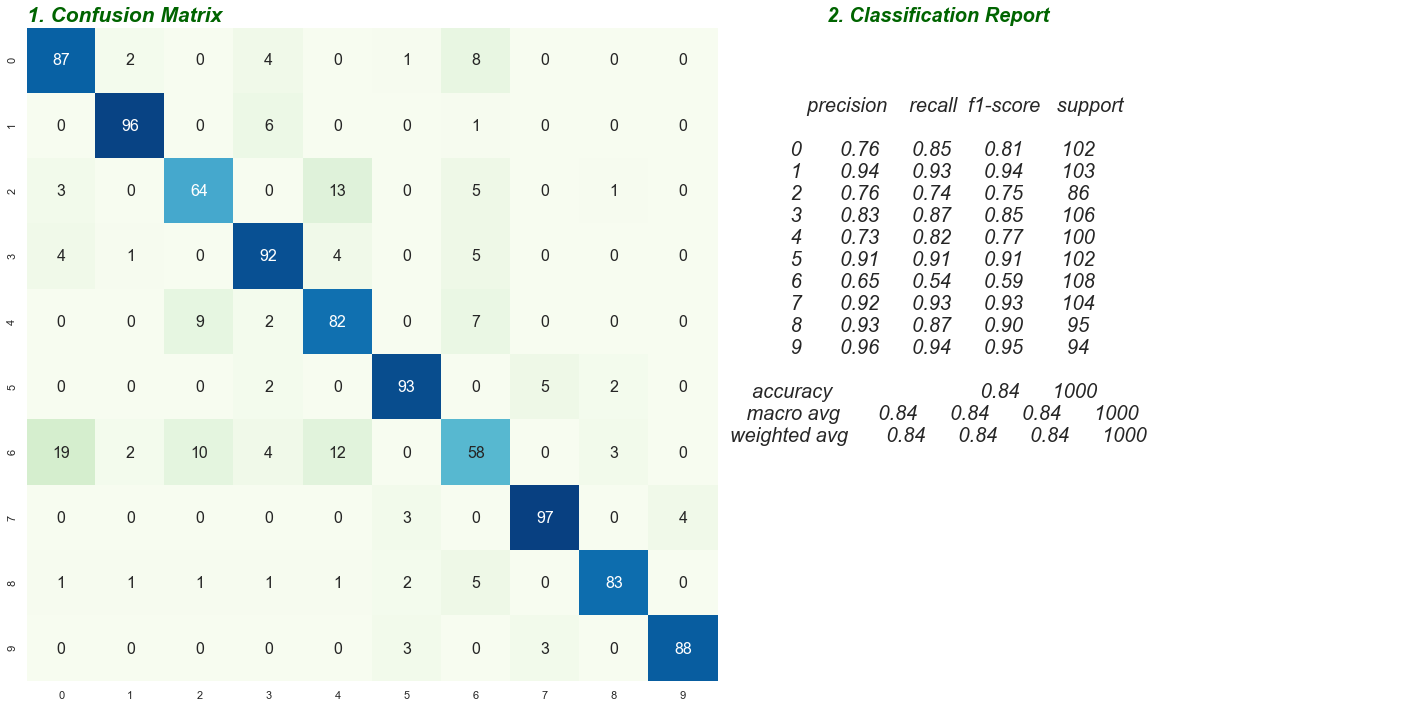

In [122]:
# Display the Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                  style='italic', loc='left', y=1.0)

# Classification Report
axes[1].axis([0, 10, 0, 3])
axes[1].text(0, 1, class_report, style='italic', fontsize=20)
axes[1].axis('off')
axes[1].set_title("2. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                  style='italic', loc='center', y=1.0, x=0.3)

plt.tight_layout()
plt.show()